### Setup Environment Variables

In [ ]:
import os
import time

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

### Initialize Bedrock Embeddings

In [ ]:
from langchain_community.embeddings import BedrockEmbeddings

bedrock_embeddings = BedrockEmbeddings(region_name=os.environ["AWS_REGION"], model_id=os.environ["AWS_LLM_EMBEDDINGS_ID"])

embeddings = bedrock_embeddings.embed_query("This is a content of the document")
print(embeddings)

### Initialize OpenAI Embeddings

In [ ]:
from langchain_openai import AzureOpenAIEmbeddings

openai_embeddings = AzureOpenAIEmbeddings(azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
                                          deployment=os.environ["AZURE_EMBEDDING_MODEL_DEPLOYMENT_NAME"],
                                          openai_api_key=os.environ["AZURE_API_KEY"])

embeddings = openai_embeddings.embed_query("This is a content of the document")
print(embeddings)

Example embedding generation

In [ ]:
embeddings = bedrock_embeddings.embed_query("This is a content of the document")
print(embeddings)

### Setup PostgreSQL related aspects - Simple Example

we can use managed PostgreSQL service from Azure. Refer to the [azure documentation](https://learn.microsoft.com/en-us/azure/postgresql/flexible-server/how-to-use-pgvector) to setup the service.

For local pgvector setup, refer [here](./docker/). Start docker and execute `docker compose up` to spin the PostgreSQL instance with pgvector enabled. We have initalization [SQL script](./docker/init_pgvector.sql) that takes care of enabling the `pgvector` extension and create an example table for further exploration.

For this example, we go with local setup.

#### Populate Embeddings Data into the table

In [ ]:
import psycopg

# Establish a connection to the PostgreSQL database
with psycopg.connect(
    user=os.environ["POSTGRES_USER"],
    password=os.environ["POSTGRES_PASSWORD"],
    host=os.environ["POSTGRES_HOST"],
    port=os.environ["POSTGRES_PORT"],  # The port you exposed in docker-compose.yml
    dbname=os.environ["POSTGRES_DB"] 
) as conn:
    
    # Open a cursor to perform database operations
    with conn.cursor() as cur:
        sentences = [
            "A group of vibrant parrots chatter loudly, sharing stories of their tropical adventures.",
            "The mathematician found solace in numbers, deciphering the hidden patterns of the universe.",
            "The robot, with its intricate circuitry and precise movements, assembles the devices swiftly.",
            "The chef, with a sprinkle of spices and a dash of love, creates culinary masterpieces.",
            "The ancient tree, with its gnarled branches and deep roots, whispers secrets of the past.",
            "The detective, with keen observation and logical reasoning, unravels the intricate web of clues.",
            "The sunset paints the sky with shades of orange, pink, and purple, reflecting on the calm sea.",
            "In the dense forest, the howl of a lone wolf echoes, blending with the symphony of the night.",
            "The dancer, with graceful moves and expressive gestures, tells a story without uttering a word.",
            "In the quantum realm, particles flicker in and out of existence, dancing to the tunes of probability.",
        ]

        # Insert sentences into the items table
        for sentence in sentences:
            embedding = bedrock_embeddings.embed_query(sentence)
            cur.execute(
                "INSERT INTO items (content, embedding) VALUES (%s, %s)",
                (sentence, embedding)
            )

#### Query embeddings based on cosine_similarity from the database.

Creating an embedding for a sample query and leveraging the <=> operator provided by pgvector allows us to perform a cosine similarity search.

It is crucial to note that pgvector actually calculates the cosine distance, which is different from cosine similarity.

Cosine distance measures the cosine of the angle between two non-zero vectors, whereas cosine similarity measures the cosine of the angle between two vectors, projecting the amount they overlap. Here's another explanation of [cosine distance and cosine similarity](https://medium.datadriveninvestor.com/cosine-similarity-cosine-distance-6571387f9bf8).

To obtain the cosine similarity from the cosine distance calculated by pgvector, we subtract the cosine distance from 1, returning results ordered by similarity

In [ ]:
# Establish a connection to the PostgreSQL database
with psycopg.connect(
    user=os.environ["POSTGRES_USER"],
    password=os.environ["POSTGRES_PASSWORD"],
    host=os.environ["POSTGRES_HOST"],
    port=os.environ["POSTGRES_PORT"],  # The port you exposed in docker-compose.yml
    dbname=os.environ["POSTGRES_DB"] 
) as conn:
    
    # Open a cursor to perform database operations
    with conn.cursor() as cur:
        # Example query
        query = "Give me some content about the ocean"
        query_embedding = bedrock_embeddings.embed_query(query)

        # Perform a cosine similarity search
        cur.execute(
            """SELECT id, content, 1 - (embedding <=> %s::vector) AS cosine_similarity
               FROM items
               ORDER BY cosine_similarity DESC LIMIT 5""",
            (query_embedding,)
        )

        # Fetch and print the result
        print("Query:", query)
        print("Most similar sentences:")
        for row in cur.fetchall():
            print(
                f"ID: {row[0]}, CONTENT: {row[1]}, Cosine Similarity: {row[2]}")

### Setup PostgreSQL related aspects - Advanced Example

we can use managed PostgreSQL service from Azure. Refer to the [azure documentation](https://learn.microsoft.com/en-us/azure/postgresql/flexible-server/how-to-use-pgvector) to setup the service.

For local pgvector setup, refer [here](./docker/). Start docker and execute `docker compose up` to spin the PostgreSQL instance with pgvector enabled. We have initalization [SQL script](./docker/init_pgvector.sql) that takes care of enabling the `pgvector` extension and create an example table for further exploration.

For this example, we go with local setup.

#### Load Sample Dataset

First, download the dataset:

In [ ]:
import wget

schema_file = "https://huggingface.co/datasets/denismagda/movies/raw/main/movie_schema.sql"
data_file = "https://huggingface.co/datasets/denismagda/movies/resolve/main/movie_data_with_openai_embeddings.sql"

print('Downloading the schema file...')
wget.download(url=schema_file, out=f"temp/movie_schema.sql")

# This file is 900MB, so it might take a minute to download it
print('Downloading the data file...')
wget.download(data_file, out=f"temp/movie_data_with_openai_embeddings.sql")

print('Finished downloading the files.')

Second, open a database connection using the psycopg2 driver:

In [ ]:
import psycopg

print('Connecting to PostgreSQL...')
conn = psycopg.connect(
    user=os.environ["POSTGRES_USER"],
    password=os.environ["POSTGRES_PASSWORD"],
    host=os.environ["POSTGRES_HOST"],
    port=os.environ["POSTGRES_PORT"],  # The port you exposed in docker-compose.yml
    dbname=os.environ["POSTGRES_DB"] 
)
    
cursor = conn.cursor()

print('Successfully connected to PostgreSQL.')

Finally, load the dataset into Postgres:

In [ ]:
print('Creating the schema...')
schema_file = open('temp/movie_schema.sql', 'r', encoding="utf8")
cursor.execute(schema_file.read())
conn.commit()

print('Loading the data. It might take a minute...')
data_file = open('temp/movie_data_with_openai_embeddings.sql', 'r', encoding="utf8")
cursor.execute(data_file.read())
conn.commit()

cursor.execute('SELECT COUNT(*) FROM movie')
result = cursor.fetchone()

print(f'{result[0]} movies loaded.')

#### Perform Vector Similarity Search

The dataset already stores a vectorized representation of movies' overviews in the overview_vector column. Each vector is a 1536-dimensional embedding generated with the OpenAI text-embedding-ada-002 model.

First, define several functions that generate vectors for user prompts and configure the matching threshold and count parameters for the similarity search:

We have created azure OpenAI service and used the embedding model from the deployment created. This is because the dataset has used OpenAI model to generate the embeddings and the same model needs to be utilized to perform a similarity search.

Mixing with different models can produce inconsistent and irrelevant results.

In [ ]:
# Converting the prompt to the pgvector embedding
def get_embedding(prompt):
    embedding = openai_embeddings.embed_query(prompt)
    return embedding

# Getting the matching threshold for the similarity search
def get_matching_threshold():
    return 0.7

# Getting the number of matching movies to return
def get_matching_count():
    return 3

Second, find the most relevant movies for a provided user prompt by calculating the cosine distance (<=>) between the prompt's and movies' embeddings:

In [ ]:
user_prompt = 'A movie about a space adventure.'

prompt_vector = get_embedding(user_prompt)

cursor.execute(
            """
                SELECT 
                    title, 
                    overview, 
                    overview_vector <=> %(prompt_vector)s::vector as cosine_distance,
                    (1 - (overview_vector <=> %(prompt_vector)s::vector)) as similarity
                FROM 
                    movie 
                WHERE 
                    overview_vector is not null 
                    AND (1 - (overview_vector <=> %(prompt_vector)s::vector)) >= %(match_threshold)s 
                ORDER BY 
                    cosine_distance ASC 
                LIMIT %(match_cnt)s
            """,
            {'prompt_vector': prompt_vector, 'match_threshold': get_matching_threshold(), 'match_cnt': get_matching_count(),}
        )

result = cursor.fetchall()

for row in result:
    print(row)

#### Pre-Filter Data Before Similarity Search

As a general-purpose relational database, PostgreSQL allows you to pre-filter data before a vector search is started. You can pre-filter by specifying a condition on non-vector columns in the `WHERE` clause of a query statement.

For instance, imagine the user selecting the `Science Fiction` category and asking to suggest movies with a rating of `7` or higher. Then, the user prompts for `A movie about a space adventure`. The final SQL query can look as follows:

In [ ]:
user_prompt = 'A movie about a space adventure.'

prompt_vector = get_embedding(user_prompt)

cursor.execute(
            """
                SELECT title, vote_average, genres, (1 - (overview_vector <=> %(prompt_vector)s::vector)) as similarity
                FROM 
                    movie 
                WHERE 
                    overview_vector is not null 
                    AND vote_average >= 7
                    AND genres @> '[{"name": "Science Fiction"}]'
                    AND (1 - (overview_vector <=> %(prompt_vector)s::vector)) >= %(match_threshold)s 
                ORDER BY 
                    similarity DESC 
                LIMIT %(match_cnt)s
            """,
            {'prompt_vector': prompt_vector, 'match_threshold': get_matching_threshold(), 'match_cnt': get_matching_count(),}
        )

result = cursor.fetchall()

for row in result:
    print(row)

PostgreSQL will pre-filter data using the following columns:

* The `vote_average` column stores a rank from `1` through `10`. 
* The `genres` column is an array of JSON objects stored in the JSONB format. A movie can be categorized by several genres, with a sample value looking as follows - `[{'id': 12, 'name': 'Adventure'}, {'id': 18, 'name': 'Drama'}, {'id': 878, 'name': 'Science Fiction'}])`

Run the `EXPLAIN` statement if you'd like to see the actual execution plan:

In [ ]:
user_prompt = 'A movie about a space adventure.'

prompt_vector = get_embedding(user_prompt)

cursor.execute(
            """
                EXPLAIN (costs off) 
                SELECT title, vote_average, genres, (1 - (overview_vector <=> %(prompt_vector)s::vector)) as similarity
                FROM 
                    movie 
                WHERE 
                    overview_vector is not null 
                    AND vote_average >= 7
                    AND genres @> '[{"name": "Science Fiction"}]'
                    AND (1 - (overview_vector <=> %(prompt_vector)s::vector)) >= %(match_threshold)s 
                ORDER BY 
                    similarity DESC 
                LIMIT %(match_cnt)s
            """,
            {'prompt_vector': prompt_vector, 'match_threshold': get_matching_threshold(), 'match_cnt': get_matching_count(),}
        )

result = cursor.fetchall()

for row in result:
    print(row)

The generated plan should look as follows:
```sql
('Limit',)
('  ->  Sort',)
("        Sort Key: ((overview_vector <=> '[0.015902195,-0.03861236,-0.02809557,...]'::vector))",)
('        ->  Seq Scan on movie',)
('              Filter: ((vote_average >= \'7\'::numeric) AND (genres @> \'[{"name": "Science Fiction"}]\'::jsonb) AND ((\'1\'::double precision - (overview_vector <=> \'[0.015902195,-0.03861236,-0.02809557,...]\'::vector)) >= \'0.7\'::double precision))',)

```

The plan indicates that the data is initially filtered by the `vote_average` and `genres` columns, followed by the similarity search on the `overview_vector` column. Note that PostgreSQL may use a different plan if you create an index for any of the columns or if other conditions change.

#### Optimize Vector Search With HNSW Index

Currently, the embeddings stored in the `overview_vector` column are not indexed. This means that the database performs an exact nearest neighbor search by comparing a user prompt's vector to all the movies' overview embeddings. You can confirm this by checking the execution plan, which will show the `Seq Scan` (full table scan) access method on the `movie` table:

In [ ]:
user_prompt = 'A movie about a space adventure.'

prompt_vector = get_embedding(user_prompt)

cursor.execute(
            """
                EXPLAIN (costs off) 
                SELECT 
                    title, 
                    overview, 
                    overview_vector <=> %(prompt_vector)s::vector as cosine_distance,
                    (1 - (overview_vector <=> %(prompt_vector)s::vector)) as similarity
                FROM 
                    movie 
                WHERE 
                    overview_vector is not null 
                    AND (1 - (overview_vector <=> %(prompt_vector)s::vector)) >= %(match_threshold)s 
                ORDER BY 
                    similarity DESC 
                LIMIT %(match_cnt)s 
            """,
            {'prompt_vector': prompt_vector, 'match_threshold': get_matching_threshold(), 'match_cnt': get_matching_count(),}
        )

result = cursor.fetchall()

for row in result:
    print(row)

Postgres pgvector supports the IVFFlat and HNSW indexes, which are two of the most widespread index types across vector databases.

Let's create an HNSW index on the embeddings stored in the `overview_vector` column:

In [ ]:
print('Building the index. It might take a minute...')

# Build the index.
#
#
# https://aiven.io/developer/postgresql-pgvector-indexes#tuning-the-hnsw-ef_construction-parameter
# m               - Number of connections to nearest neighbors (vertices) made per point per layer within the index.
#
# https://aiven.io/developer/postgresql-pgvector-indexes#tuning-the-hnsw-ef_construction-parameter
# ef_construction - Defines the size of the closest candidate list used during the index building process. 
#                   The list contains the closest candidates found so far while traversing the graph. 
#                   Once the traversal is finished, the list is sorted and only the first m links are kept.
cursor.execute(
    'CREATE INDEX movie_overview_hnsw_idx ON movie '
    'USING hnsw (overview_vector vector_cosine_ops) '
    'WITH (m = 4, ef_construction = 10)')
conn.commit()

# Update the statistics for the query planner
# to ensure that the index is used for the vector similarity search
conn.autocommit = True
cursor.execute(
    'VACUUM ANALYZE movie')
conn.autocommit = False

print('HNSW Index created.')

Check the execution plan once more for the previous query to ensure that Postgres now expedites the similarity search with the newly created index. You will see the `Index Scan` access method on the `movie` table:

In [ ]:
%%time
user_prompt = 'A movie about a space adventure.'

prompt_vector = get_embedding(user_prompt)

# Note that we have used a different expression in the ORDER BY clause to use the index.
# Also, index shall function only with ASC order.
cursor.execute(
            """
                --EXPLAIN (costs off) 
                SELECT 
                    title, 
                    overview,
                    overview_vector <=> %(prompt_vector)s::vector as cosine_distance, 
                    (1 - (overview_vector <=> %(prompt_vector)s::vector)) as similarity
                FROM 
                    movie 
                WHERE 
                    overview_vector is not null 
                    AND (1 - (overview_vector <=> %(prompt_vector)s::vector)) >= %(match_threshold)s 
                ORDER BY 
                    cosine_distance ASC
                LIMIT %(match_cnt)s 
            """,
            {'prompt_vector': prompt_vector, 'match_threshold': get_matching_threshold(), 'match_cnt': get_matching_count(),}
        )

result = cursor.fetchall()

for row in result:
    print(row)

### Additional References

Deep dive on HNSW index:

https://www.crunchydata.com/blog/hnsw-indexes-with-postgres-and-pgvector

Number of vectors vs Total Size

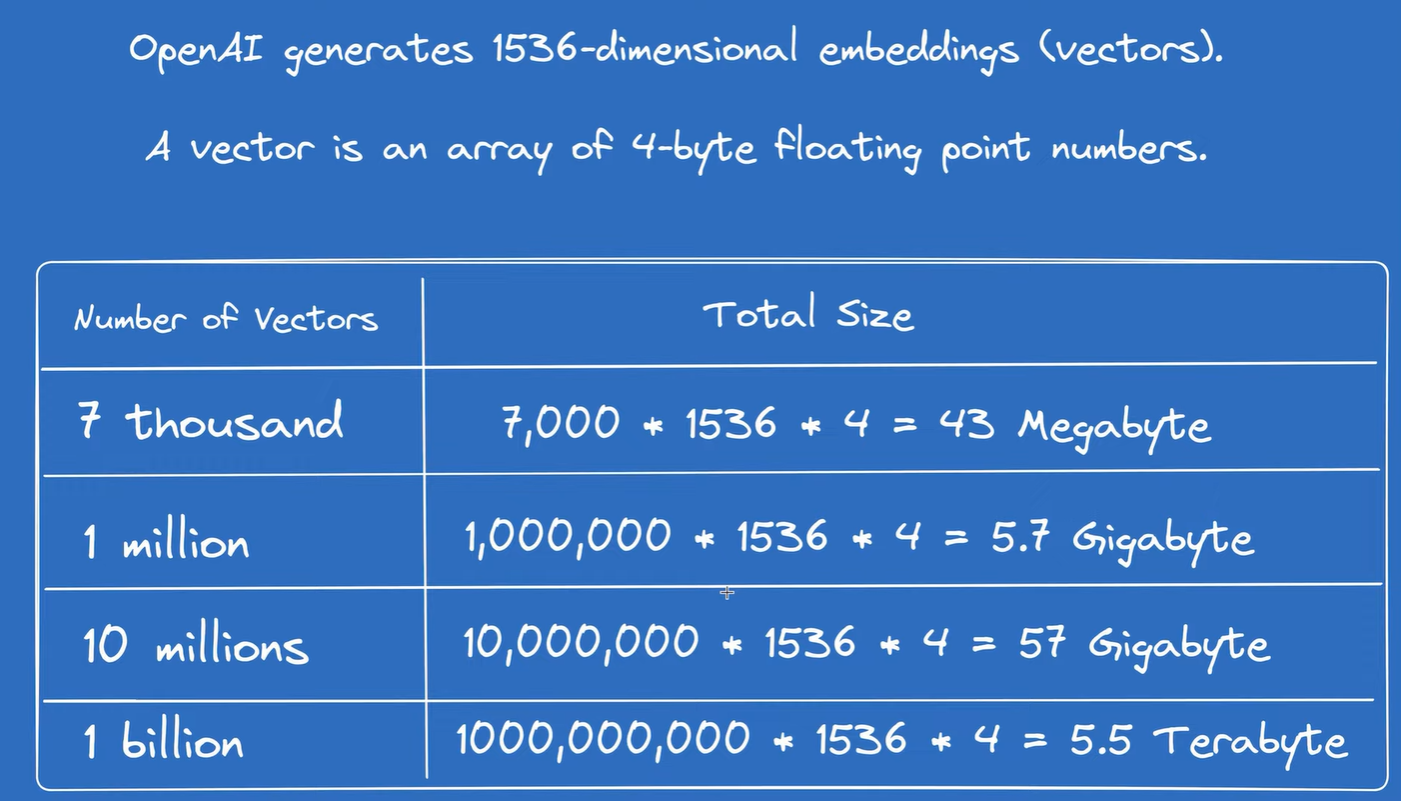